In [22]:
import geopandas as gp
import pandas as pd
from  matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from cuda_with_launcher import *
import numpy as np
from scipy.optimize import curve_fit
from cuda_with_launcher.geoplot import *

In [23]:
variables = ["gdp_capita", "permeability", "offset"]
variables_to_labels = {
    "gdp_capita" : "PIB per cápita",
    "permeability" : "Permeabilidad",
    "offset" : "Retraso muertes",
    "1/permeability" : r"Permeabilidad$^-1$",
    "initial_i" : r"$\rho_I (t=0)$",
    "what" : r"$\xi$",
}
variables_to_units = {
    "gdp_capita" : r"(1k\$·año$^{-1}$)",
    "permeability" : "(%)",
    "offset" : "(días)",
    "1/permeability" : r"(%$^-1$)",
    "initial_i" : "(%)",
    "what" : r"(días$^{-1}$)",
}
def get_labels(v):
    return list(map(lambda x: variables_to_labels[x], variables))

In [24]:
world = read_geo_frame()
world = update_geo_frame(world)
all_countries = get_all_countries()
world_only_used = world[list(w in all_countries for w in world.get("name"))].copy()
# save_geo_frame(world)

Canada
United States of America
Indonesia
Argentina
Chile
Russian Federation
South Africa
Mexico
Bolivia (Plurinational State of
Colombia
Panama
Honduras
Guatemala
France
Nigeria
Israel
United Arab Emirates
Kuwait
Iraq
Bangladesh
Pakistan
Ukraine
Poland
Austria
Hungary
Romania
Bulgaria
Greece
Turkey
Switzerland
Luxembourg
Belgium
Portugal
Spain
Ireland
Italy
United Kingdom of Great Britain
Philippines
Malaysia
Saudi Arabia
Morocco
Egypt


In [25]:
# variables = ["gdp_capita", "permeability", "offset"]
# w_p = world[variables]

# lims = {
#     "gdp_capita": {"xmin":0, "ymin":0, "xmax":150e3, "ymax":150e3},
#     "permeability": {"xmin":0, "ymin":0, "xmax":1, "ymax":1},
#     "offset" : {"xmin":0, "ymin":0}
#     }

# g = seaborn.pairplot(w_p, corner=True, size=4)#,diag_kind='kde')
# for i,v_1 in enumerate(variables):
#     for j, v_2 in enumerate(variables):
#         if i>j :
#             continue
#         try:
#             g.axes[i,j].set_xlim(xmin=lims[v_2].get("xmin", None), xmax=lims[v_2].get("xmax", None))
#             g.axes[i,j].set_ylim(ymin=lims[v_1].get("ymin", None), ymax=lims[v_2].get("ymax", None))
#         except AttributeError as e:
#             continue
    

# g.map_lower(seaborn.kdeplot, levels=3, color=".2")


C:\Users\QuanticPony\AppData\Local\Temp\ipykernel_19584\1760924617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_p["1/permeability"] = 1/w_p["permeability"]


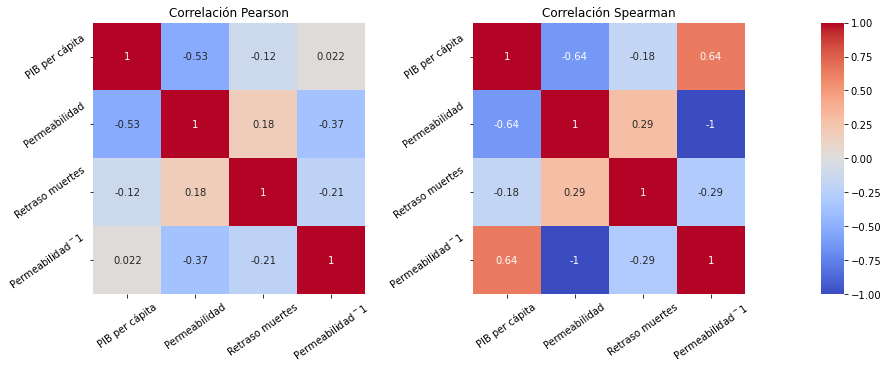

In [26]:
variables = ["gdp_capita", "permeability", "offset", "1/permeability"]

labels = get_labels(variables)

w_p = world[["gdp_capita", "permeability", "offset"]]
w_p["1/permeability"] = 1/w_p["permeability"]

corr_p = w_p.corr('pearson') 
corr_s = w_p.corr('spearman')
fig, (ax1,ax2, ax_cb) = plt.subplots(ncols=3, figsize=(14,5), gridspec_kw={'width_ratios': [15,15, 1]})

p = seaborn.heatmap(corr_p, cmap="coolwarm", vmin=-1, vmax=1, annot=True, ax=ax1, square=True, cbar=False)
ax1.set_xticks(np.arange(corr_p.select_dtypes(['number']).shape[1])+0.5, labels, fontsize=10, rotation=35)
ax1.set_yticks(np.arange(corr_p.select_dtypes(['number']).shape[1])+0.5, labels, fontsize=10, rotation=35)

ax1.set_title("Correlación Pearson")

s = seaborn.heatmap(corr_s, cmap="coolwarm", vmin=-1, vmax=1, annot=True, ax=ax2, square=True, cbar_ax=ax_cb)
ax2.set_xticks(np.arange(corr_s.select_dtypes(['number']).shape[1])+0.5, labels, fontsize=10, rotation=35)
ax2.set_yticks(np.arange(corr_s.select_dtypes(['number']).shape[1])+0.5, labels, fontsize=10, rotation=35)

ax2.set_title("Correlación Spearman")

fig.savefig("images/coeficientes.png", dpi=600)

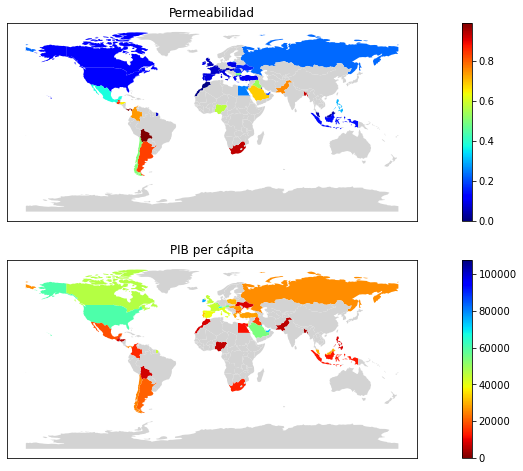

In [27]:
variables = ["permeability", "gdp_capita"]
cmap = "jet"


fig, *axs = plt.subplots(nrows=len(variables), figsize=(8*len(variables), 8))

for a, v  in zip(axs[0], variables):
    a.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

    norm = Normalize(0, world_only_used.get(v).max())
    world.plot(v, 
        cmap=cmap + ("_r" if v=='gdp_capita' else ''), 
        norm=norm, 
        legend=True, 
        ax=a, 
        missing_kwds={'color': 'lightgrey'})
        
    a.set_title(variables_to_labels[v])
fig.savefig("images/comparacion mundo.png", dpi=600)

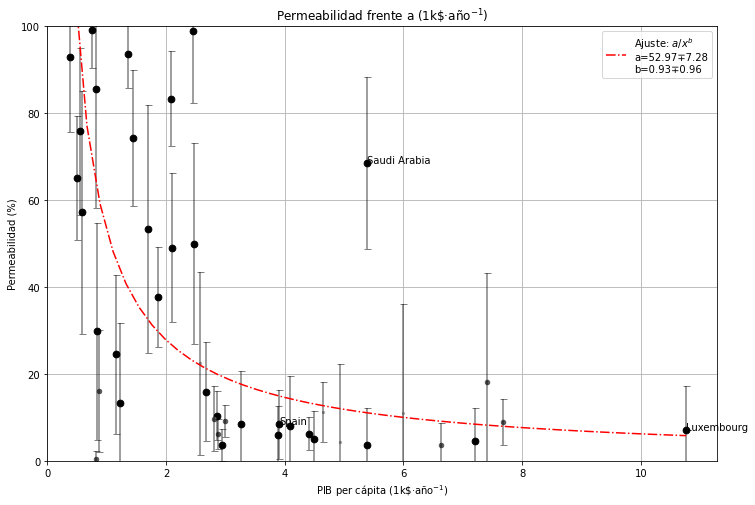

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.tick_params(left=True,
                bottom=True,
                labelleft=True,
                labelbottom=True)
    
x = 'gdp_capita'
y = 'permeability'
cmap = 'binary'
cnorm = Normalize(0, 3)

all_countries = get_all_countries()
for index, row in world.iterrows():
    if not np.isnan(row[y]):
        if row['name'] in all_countries:
            # if row['name']=="Morocco":
            #     continue
            
            _X = row[x]/10e3
            _Y = row[y]*100
            _S = row[y+"_err"]*100
            # _Y = 1/_Y
            
            config = configuration.read_configuration(row['name'], prefix='used/', sufix='')

            ax.scatter(_X, _Y, s=5*config["score"]**2, c=config["score"], cmap=cmap, norm=cnorm)
            ax.errorbar(_X, _Y, yerr=_S, ecolor='black', capsize=3.5, fmt='none', alpha=0.5)
            if row['name'] in ["Saudi Arabia", "Luxembourg", "Spain", ]:
                ax.annotate(row["name"], (float(_X), float(_Y)))

ax.set_title("Permeabilidad frente a PIB per cápita")
ax.set_title(f"{variables_to_labels[y]} frente a {variables_to_units[x]}")
ax.set_xlabel(f"{variables_to_labels[x]} {variables_to_units[x]}")
ax.set_ylabel(f"{variables_to_labels[y]} {variables_to_units[y]}")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0, ymax=100)
# ax.set_ylim(ymin=0, ymax=0.4)
ax.grid(True)

def fit_curve(x, a, b):
    return a / np.power(x, b)


## Solo estoy haciendo el ajuste con los que considero que han ajustado bien
_X = world_only_used[world_only_used["score"]==3].get(x)/10e3
_Y = world_only_used[world_only_used["score"]==3].get(y)*100
_S = world_only_used[world_only_used["score"]==3].get(y+'_err')*100

popt, pcov = curve_fit(fit_curve, _X, _Y, sigma=_S, p0=(0.7,2))

x_data = np.linspace(0.01, _X.max())
y_data = fit_curve(x_data, *popt)

ax.plot(x_data, y_data, '-.', color='red', label=f"Ajuste: $a/x^b$\na={popt[0]:.2f}∓{np.sqrt(popt[0]):.2f}\nb={popt[1]:.2f}∓{np.sqrt(popt[1]):.2f}")
ax.legend()
        
fig.savefig("images/perme-pib.png", dpi=600)

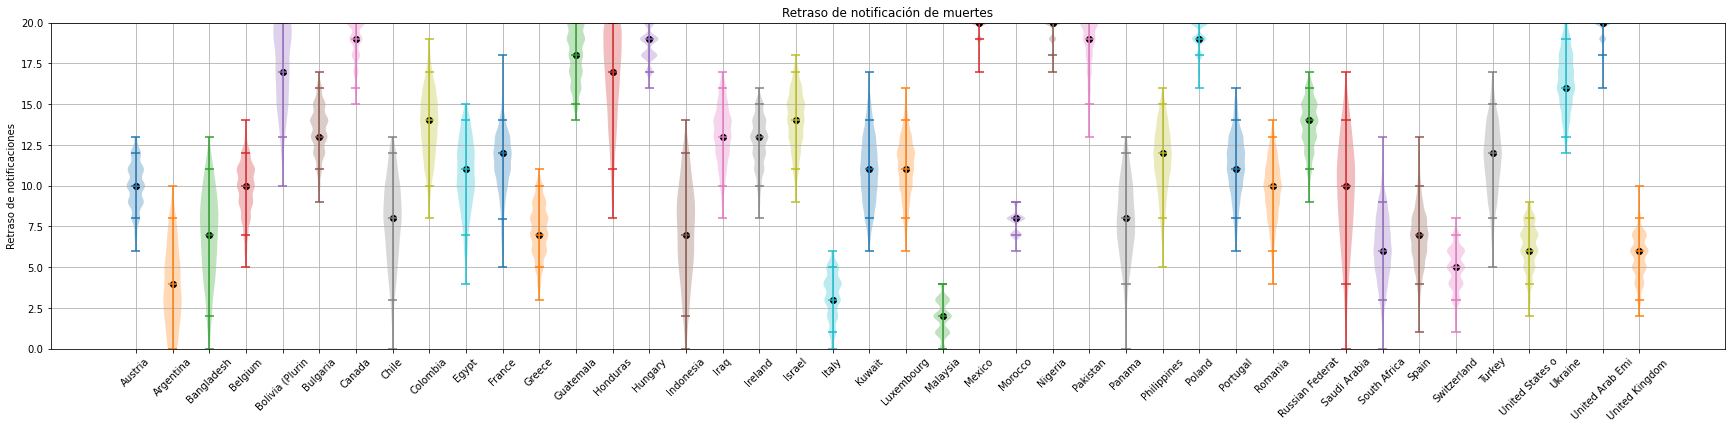

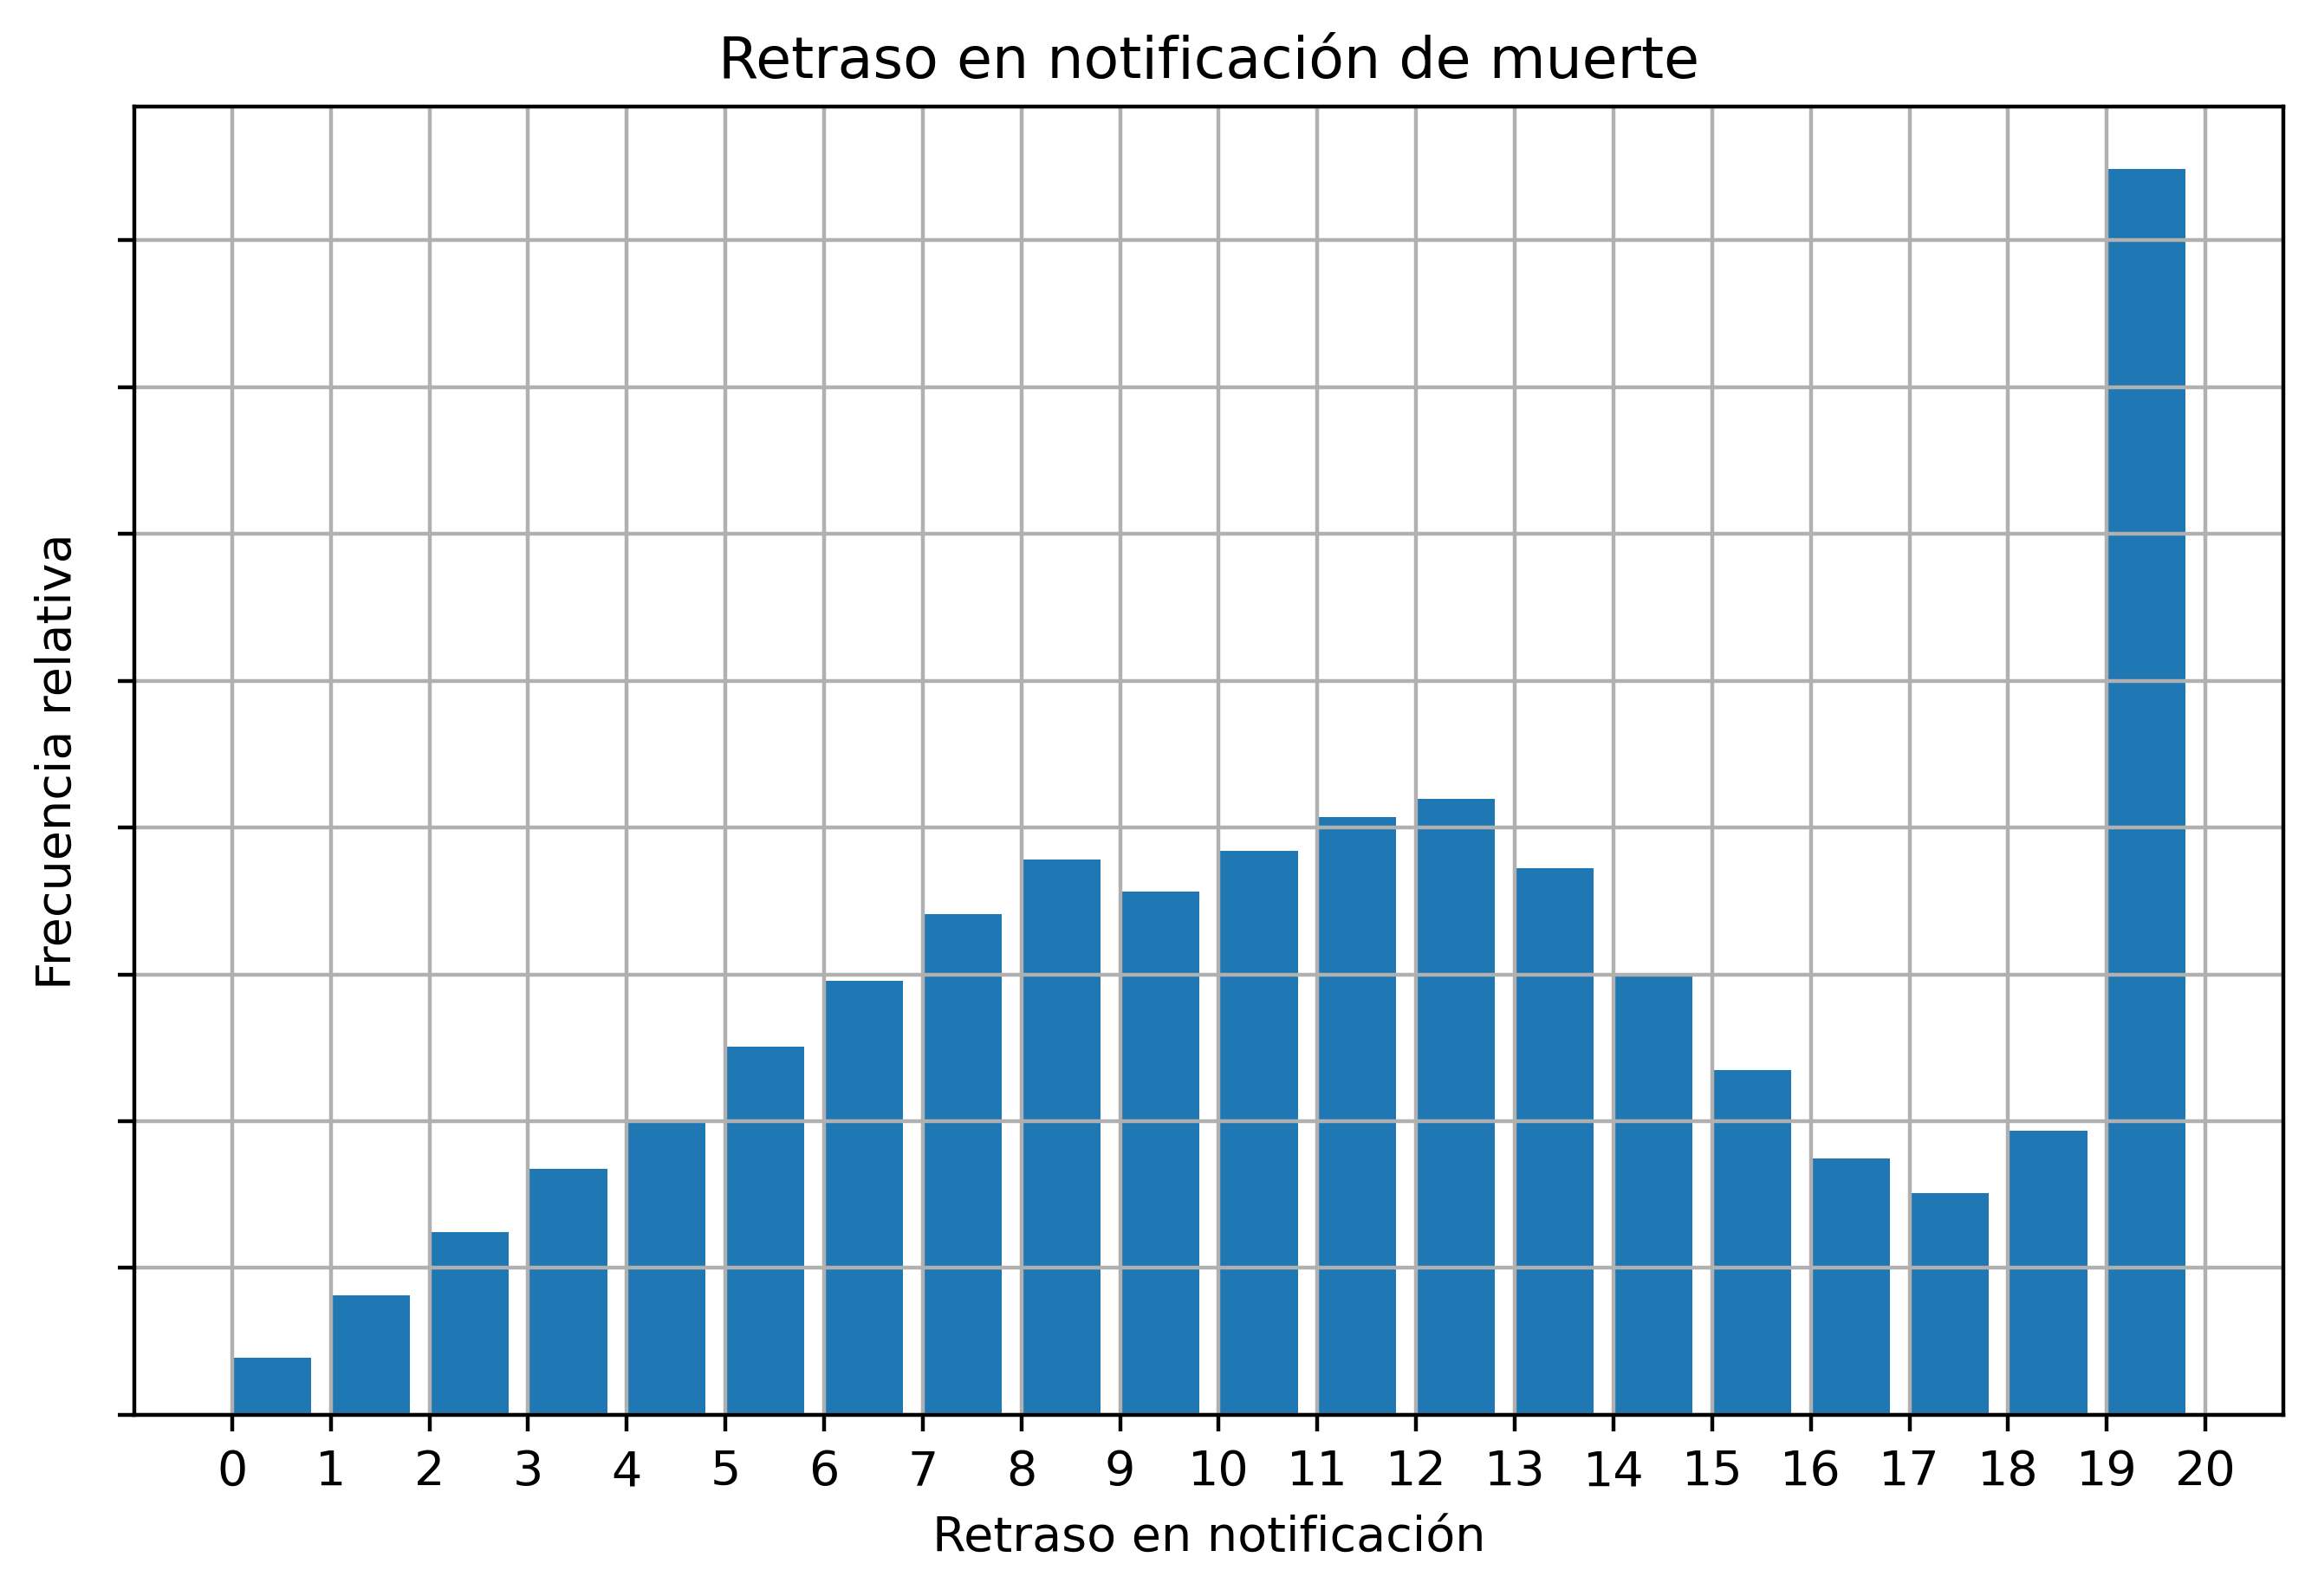

In [29]:
fig1, ax1= plt.subplots(figsize=(30,6))
values = []
values_5 = []
values_95 = []
errs = []
scores = []

bins = np.arange(21)
sum_histogram = np.zeros(20)

for i, c in enumerate(all_countries):
    try:
        files = analysis.open_save_files(c, erase_prev=False, mode='r')
    except FileNotFoundError:
        continue

    v_array = []
    for l in files["offset"]:
        v_array.append(float(l))
    v_array = np.array(v_array)
    v_array.sort()

    _5 = analysis.percentil(v_array, 5)
    _95 = analysis.percentil(v_array, 95)
    _median = analysis.percentil(v_array, 50)
    _err = v_array.std()
    score = world_only_used.loc[world_only_used["name"]==c]["score"]


    histogram, bins_edges = np.histogram(v_array, bins=bins)
    sum_histogram += histogram * float(score)

    scores.append(score)
    values.append(_median)
    values_5.append(_5)
    values_95.append(_95)
    errs.append(_err*3/score)

    # ax1.boxplot(v_array, positions=[i], widths=score/3, notch=False)
    ax1.violinplot(v_array, positions=[i], showmedians=True, quantiles=[0.05, 0.95])
    ax1.scatter(i, _median, color='black')
    # ax1.scatter(i, _5, color='red')
    # ax1.scatter(i, _95, color='blue')

    # , usermedians=[_median], conf_intervals=[(_5, _95)]

values = np.array(values)
errs = np.array(errs)
scores = np.array(scores)
values_5 = np.array(values_5)
values_95 = np.array(values_95)

ax1.set_title("Retraso de notificación de muertes")
ax1.set_ylabel("Retraso de notificaciones")
ax1.set_xticks(range(len(all_countries)), [c if len(c)<15 else c[:15] for c in all_countries], rotation=45)
ax1.grid(True)
ax1.set_ylim(0, 20)
fig1.savefig("images/violin offset.png", dpi=600)

fig2, ax2 = plt.subplots(figsize=(8,5))
ax2.set_title("Retraso en notificación de muerte")
ax2.set_xlabel("Retraso en notificación")
ax2.set_ylabel("Frecuencia relativa")

ax2.grid(True)
ax2.bar(bins_edges[:-1], sum_histogram, align='edge')
ax2.set_xticks(bins)
# bins = int(max(values)) - int(min(values))
# ax2.hist(values, bins=bins, weights=scores, alpha=0.3)
# ax2.hist(values_5, bins=bins, weights=scores, alpha=0.3, color="orange")
# ax2.hist(values_95, bins=bins, weights=scores, alpha=0.3, color="green")


ax2.set_yticklabels([])
fig2.set_dpi(400)
fig2.savefig("images/retraso notificacion.png", dpi=600)